IMPORT DEPENDENCIES

In [106]:
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
import momepy as mp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import nx_altair as nxa
import shapely.geometry as geom
from itertools import islice
from collections import Counter
import sklearn as sk
from sklearn.cluster import KMeans
from tqdm import tqdm
import torch
import dgl

In [2]:
place_name = "Manhattan Island, New York, United States"
G = ox.graph_from_place(place_name, network_type= 'drive', simplify = True)

In [3]:
area = ox.geocode_to_gdf(place_name)

EVICTION GRAPH

In [4]:
#Load eviction data and filter data for Manhattan only
eviction_data = open(r"C:\Users\jfoo\OneDrive - tvsdesign\Desktop\MACAD\AIA\Studio\AIA-GML-James-Andres\Data\Evictions_20240516.csv")
eviction_df = pd.read_csv(eviction_data)
manhattan_evictions = eviction_df[eviction_df['BOROUGH'] == 'MANHATTAN']
clean_evictions = manhattan_evictions.dropna(subset = 'Latitude')

In [5]:
geometry = gpd.points_from_xy(clean_evictions['Longitude'], clean_evictions['Latitude'])
manhattan_evictions_gdf = gpd.GeoDataFrame(clean_evictions, geometry= geometry)
manhattan_evictions_gdf.set_crs(epsg= 4326)

Court Index Number  Docket Number               Eviction Address  \
3               74670/16           61667        535 WEST 110TH STREE T   
10             311118/22            6085  2915 FREDERICK DOUGLASS BLVD   
14              59878/19           18419        620 WEST 172ND STREE T   
36              82266/16            9013              220 CABRINI BLVD   
39             N60311/19           97948        267 WEST 146TH STREE T   
...                  ...             ...                           ...   
91169           21087/18           34034             442 EAST 105TH ST   
91195          080658/17           80051         106-108 WEST 109TH ST   
91196           65769/19          357421          243 EAST 83RD STREET   
91197           65769/19          357421          243 EAST 83RD STREET   
91199          310455/23          121412            214 AUDUBON AVENUE   

      Eviction Apartment Number Executed Date Marshal First Name  \
3                            3A    05/04/2017             Justin   
10                           4C    03/05/2024              David   
14                           4A    08/13/2019             George   
36                           3D    01/30/2018             George   
39                           16    10/03/2019             Ileana   
...                         ...           ...                ...   
91169                       05B    05/07/2019              Bruce   
91195                        3C    03/02/2018              Henry   
91196                        5C    12/12/2019             Thomas   
91197                        5C    12/12/2019             Thomas   
91199                        46    10/05/2023             Justin   

      Marshal Last Name Residential/Commercial    BOROUGH  Eviction Postcode  \
3              Grossman            Residential  MANHATTAN              10025   
10                Smith            Residential  MANHATTAN              10039   
14          Essock, Jr.            Residential  MANHATTAN              10032   
36          Essock, Jr.            Residential  MANHATTAN              10033   
39               Rivera            Residential  MANHATTAN              10039   
...                 ...                    ...        ...                ...   
91169              Kemp            Residential  MANHATTAN              10029   
91195             Daley            Residential  MANHATTAN              10025   
91196               Bia            Residential  MANHATTAN              10028   
91197               Bia            Residential  MANHATTAN              10028   
91199          Grossman            Residential  MANHATTAN              10033   

       ... Eviction/Legal Possession   Latitude  Longitude  Community Board  \
3      ...                Possession  40.803795 -73.965797              9.0   
10     ...                Possession  40.828736 -73.937611             10.0   
14     ...                Possession  40.844060 -73.939327             12.0   
36     ...                Possession  40.854901 -73.938490             12.0   
39     ...                Possession  40.823075 -73.940380             10.0   
...    ...                       ...        ...        ...              ...   
91169  ...                  Eviction  40.788265 -73.938952             11.0   
91195  ...                Possession  40.801398 -73.962010              7.0   
91196  ...                Possession  40.776451 -73.954395              8.0   
91197  ...                Possession  40.776451 -73.954395              8.0   
91199  ...                Possession  40.845364 -73.934812             12.0   

       Council District  Census Tract        BIN           BBL  \
3                   7.0         199.0  1056904.0  1.018820e+09   
10                  9.0       23502.0  1060897.0  1.020470e+09   
14                 10.0         253.0  1063486.0  1.021420e+09   
36                 10.0         275.0  1064369.0  1.021790e+09   
39                  9.0         234.0  1060499.0  1.020320e+

In [6]:
eviction_gdf_points = manhattan_evictions_gdf[manhattan_evictions_gdf['geometry'].type == 'Point']
eviction_gdf_points.head()

Court Index Number  Docket Number               Eviction Address  \
3            74670/16           61667        535 WEST 110TH STREE T   
10          311118/22            6085  2915 FREDERICK DOUGLASS BLVD   
14           59878/19           18419        620 WEST 172ND STREE T   
36           82266/16            9013              220 CABRINI BLVD   
39          N60311/19           97948        267 WEST 146TH STREE T   

   Eviction Apartment Number Executed Date Marshal First Name  \
3                         3A    05/04/2017             Justin   
10                        4C    03/05/2024              David   
14                        4A    08/13/2019             George   
36                        3D    01/30/2018             George   
39                        16    10/03/2019             Ileana   

   Marshal Last Name Residential/Commercial    BOROUGH  Eviction Postcode  \
3           Grossman            Residential  MANHATTAN              10025   
10             Smith            Residential  MANHATTAN              10039   
14       Essock, Jr.            Residential  MANHATTAN              10032   
36       Essock, Jr.            Residential  MANHATTAN              10033   
39            Rivera            Residential  MANHATTAN              10039   

    ... Eviction/Legal Possession   Latitude  Longitude  Community Board  \
3   ...                Possession  40.803795 -73.965797              9.0   
10  ...                Possession  40.828736 -73.937611             10.0   
14  ...                Possession  40.844060 -73.939327             12.0   
36  ...                Possession  40.854901 -73.938490             12.0   
39  ...                Possession  40.823075 -73.940380             10.0   

    Council District  Census Tract        BIN           BBL  \
3                7.0         199.0  1056904.0  1.018820e+09   
10               9.0       23502.0  1060897.0  1.020470e+09   
14              10.0         253.0  1063486.0  1.021420e+09   
36              10.0         275.0  1064369.0  1.021790e+09   
39               9.0         234.0  1060499.0  1.020320e+09   

                                  NTA                    geometry  
3                 Morningside Heights  POINT (-73.96580 40.80380)  
10  Central Harlem North-Polo Grounds  POINT (-73.93761 40.82874)  
14           Washington Heights South  POINT (-73.93933 40.84406)  
36           Washington Heights North  POINT (-73.93849 40.85490)  
39  Central Harlem North-Polo Grounds  POINT (-73.94038 40.82308)  

[5 rows x 21 columns]

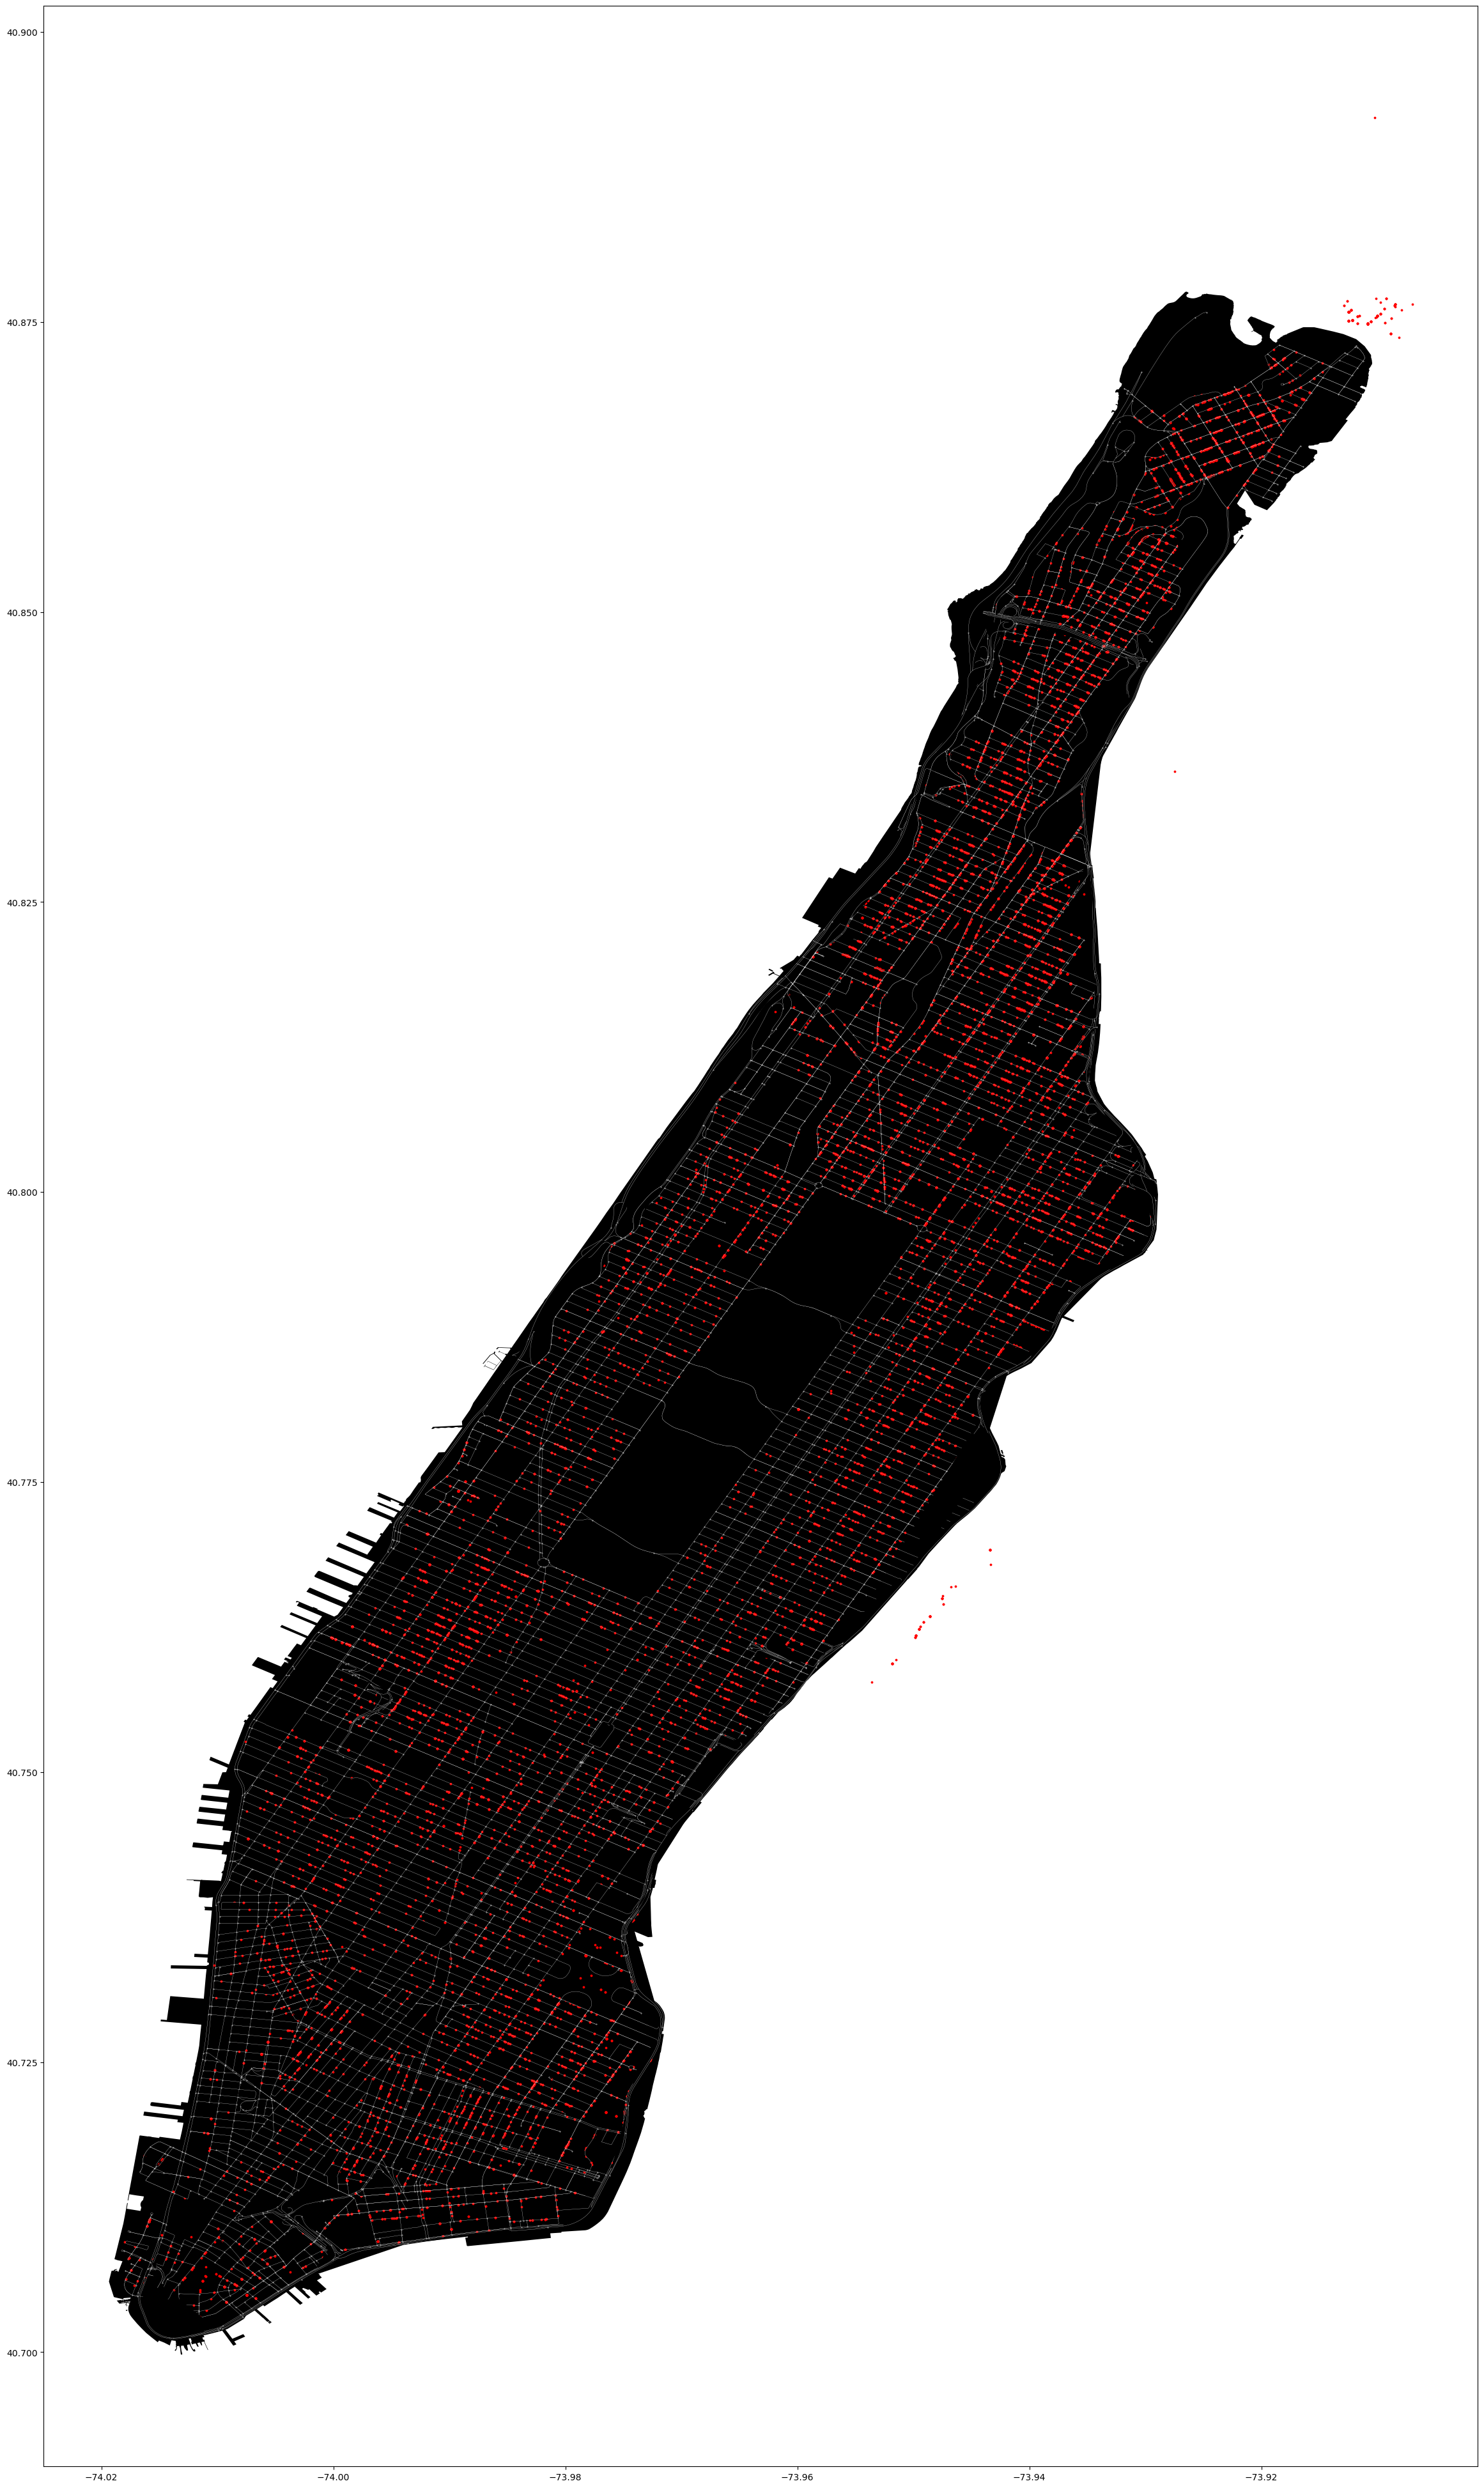

In [7]:
nodes, edges = ox.graph_to_gdfs(G)
fig, ax = plt.subplots(figsize=(30,50))
area.plot(ax = ax, facecolor = 'black')
edges.plot(ax = ax, linewidth = 0.2, edgecolor = 'white', facecolor = 'black')
nodes.plot(ax= ax, color = 'white', markersize = .1)
eviction_gdf_points.plot(ax= ax, markersize = 3, color = 'red')

plt.show()

In [38]:
#Count number of evicictions for each edge
close_edges = ox.distance.nearest_edges(G, eviction_gdf_points['geometry'].x, eviction_gdf_points['geometry'].y)
eviction_count = Counter(close_edges)
evictions = []

#Assign value to each edge
for i in edges.index:
    eviction = eviction_count[edges.loc[i].name]
    evictions.append(eviction)

max(evictions)
edges['evictions'] = evictions

In [119]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()

(array([2.197e+03, 4.600e+02, 2.480e+02, 1.360e+02, 1.020e+02, 8.500e+01,
        4.100e+01, 2.600e+01, 2.100e+01, 1.000e+01, 8.000e+00, 7.000e+00,
        4.000e+00, 4.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-0.57396245, -0.16498799,  0.24398646,  0.65296092,  1.06193537,
         1.47090983,  1.87988428,  2.28885873,  2.69783319,  3.10680764,
         3.5157821 ,  3.92475655,  4.33373101,  4.74270546,  5.15167992,
         5.56065437,  5.96962882,  6.37860328,  6.78757773,  7.19655219,
         7.60552664,  8.0145011 ,  8.42347555,  8.83245001,  9.24142446,
         9.

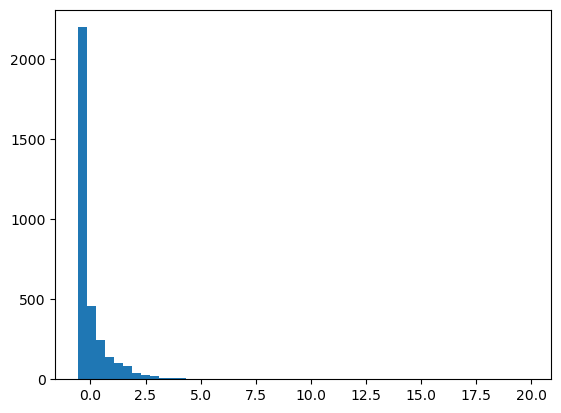

In [136]:
non_zero_evictions = edges[edges['evictions'] != 0]
non_zero_evictions['scaled_evictions'] = scalar.fit_transform(non_zero_evictions['evictions'].values.reshape(-1,1))
plt.hist(non_zero_evictions['scaled_evictions'].values, bins = 50)

In [160]:

for edge, value in scaled_evictions


TypeError: 'value' parameter must be None, a scalar geometry, or a GeoSeries, but you passed a 'int'

In [149]:
edges

osmid  \
u           v          key                                                      
42421728    42435337   0                                            195743153   
            42421731   0                      [420625565, 420625573, 5668966]   
            42432736   0                             [1271523197, 1271523198]   
42435337    42437916   0                                              5670640   
            42421728   0                                            195743153   
...                                                                       ...   
6216836461  42448283   0                                            668153180   
6331080434  42451018   0                                            676028733   
9566822907  9566822912 0                                           1038856010   
11868048948 42423752   0    [32947297, 544616716, 544616717, 198924630, 19...   
11868048950 42423579   0                                            198924625   

                                                                         name  \
u           v          key                                                      
42421728    42435337   0                                    Central Park West   
            42421731   0                                    West 106th Street   
            42432736   0                                    Central Park West   
42435337    42437916   0                                    West 105th Street   
            42421728   0                                    Central Park West   
...                                                                       ...   
6216836461  42448283   0                                    East 117th Street   
6331080434  42451018   0                                    Peter Cooper Road   
9566822907  9566822912 0                                                    0   
11868048948 42423752   0    [Queensboro Bridge Exit, Ed Koch Queensboro Br...   
11868048950 42423579   0                Ed Koch Queensboro Bridge Lower Level   

                                  highway          maxspeed  oneway reversed  \
u           v          key                                                     
42421728    42435337   0        secondary            25 mph   False     True   
            42421731   0        secondary                 0   False    False   
            42432736   0        secondary            25 mph   False    False   
42435337    42437916   0      residential            25 mph    True    False   
            42421728   0        secondary            25 mph   False    False   
...                                   ...               ...     ...      ...   
6216836461  42448283   0      residential                 0    True    False   
6331080434  42451018   0      residential            25 mph    True    False   
9566822907  9566822912 0    motorway_link                 0    True    False   
11868048948 42423752   0            trunk  [30 mph, 15 mph]    True    False   
11868048950 42423579   0            trunk            30 mph    True    False   

                             length  \
u           v          key            
42421728    42435337   0     85.345   
            42421731   0    138.033   
            42432736   0     86.274   
42435337    42437916   0    137.996   
            42421728   0     85.345   
...                             ...   
6216836461  42448283   0     65.177   
6331080434  42451018   0     13.441   
9566822907  9566822912 0     24.714   
11868048948 42423752   0    517.233   
11868048950 42423579   0    127.969   

                                                                     geometry  \
u           v          key                                                      
42421728    42435337   0    LINESTRING (-73.96004 40.79805, -73.96011 40.7...   
            42421731   0    LINESTRING (-73.96004 40.79805, -73.96017 40.7...   
            42432736   0    LINESTRING (-73.96004 40.79805, -73.95996 40.7...   
42435337  

(array([6.335e+03, 1.123e+03, 1.074e+03, 4.600e+02, 3.840e+02, 2.100e+02,
        8.700e+01, 2.000e+01, 3.000e+00, 3.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

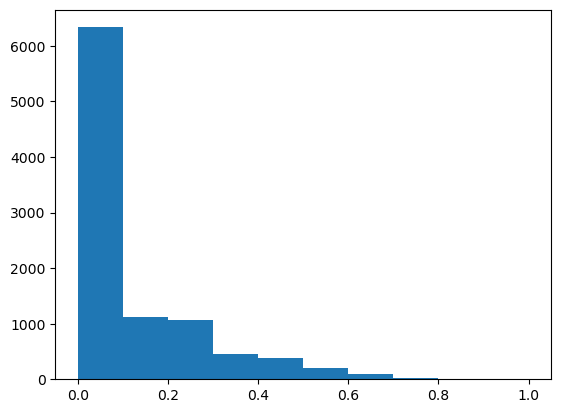

In [47]:

scaled_weights = np.log(edges['evictions']+1)
normalized_evictions = (log_weights - log_weights.min()) / (log_weights.max() - log_weights.min())
plt.hist(normalized_evictions)

IndexError: indices are out-of-bounds

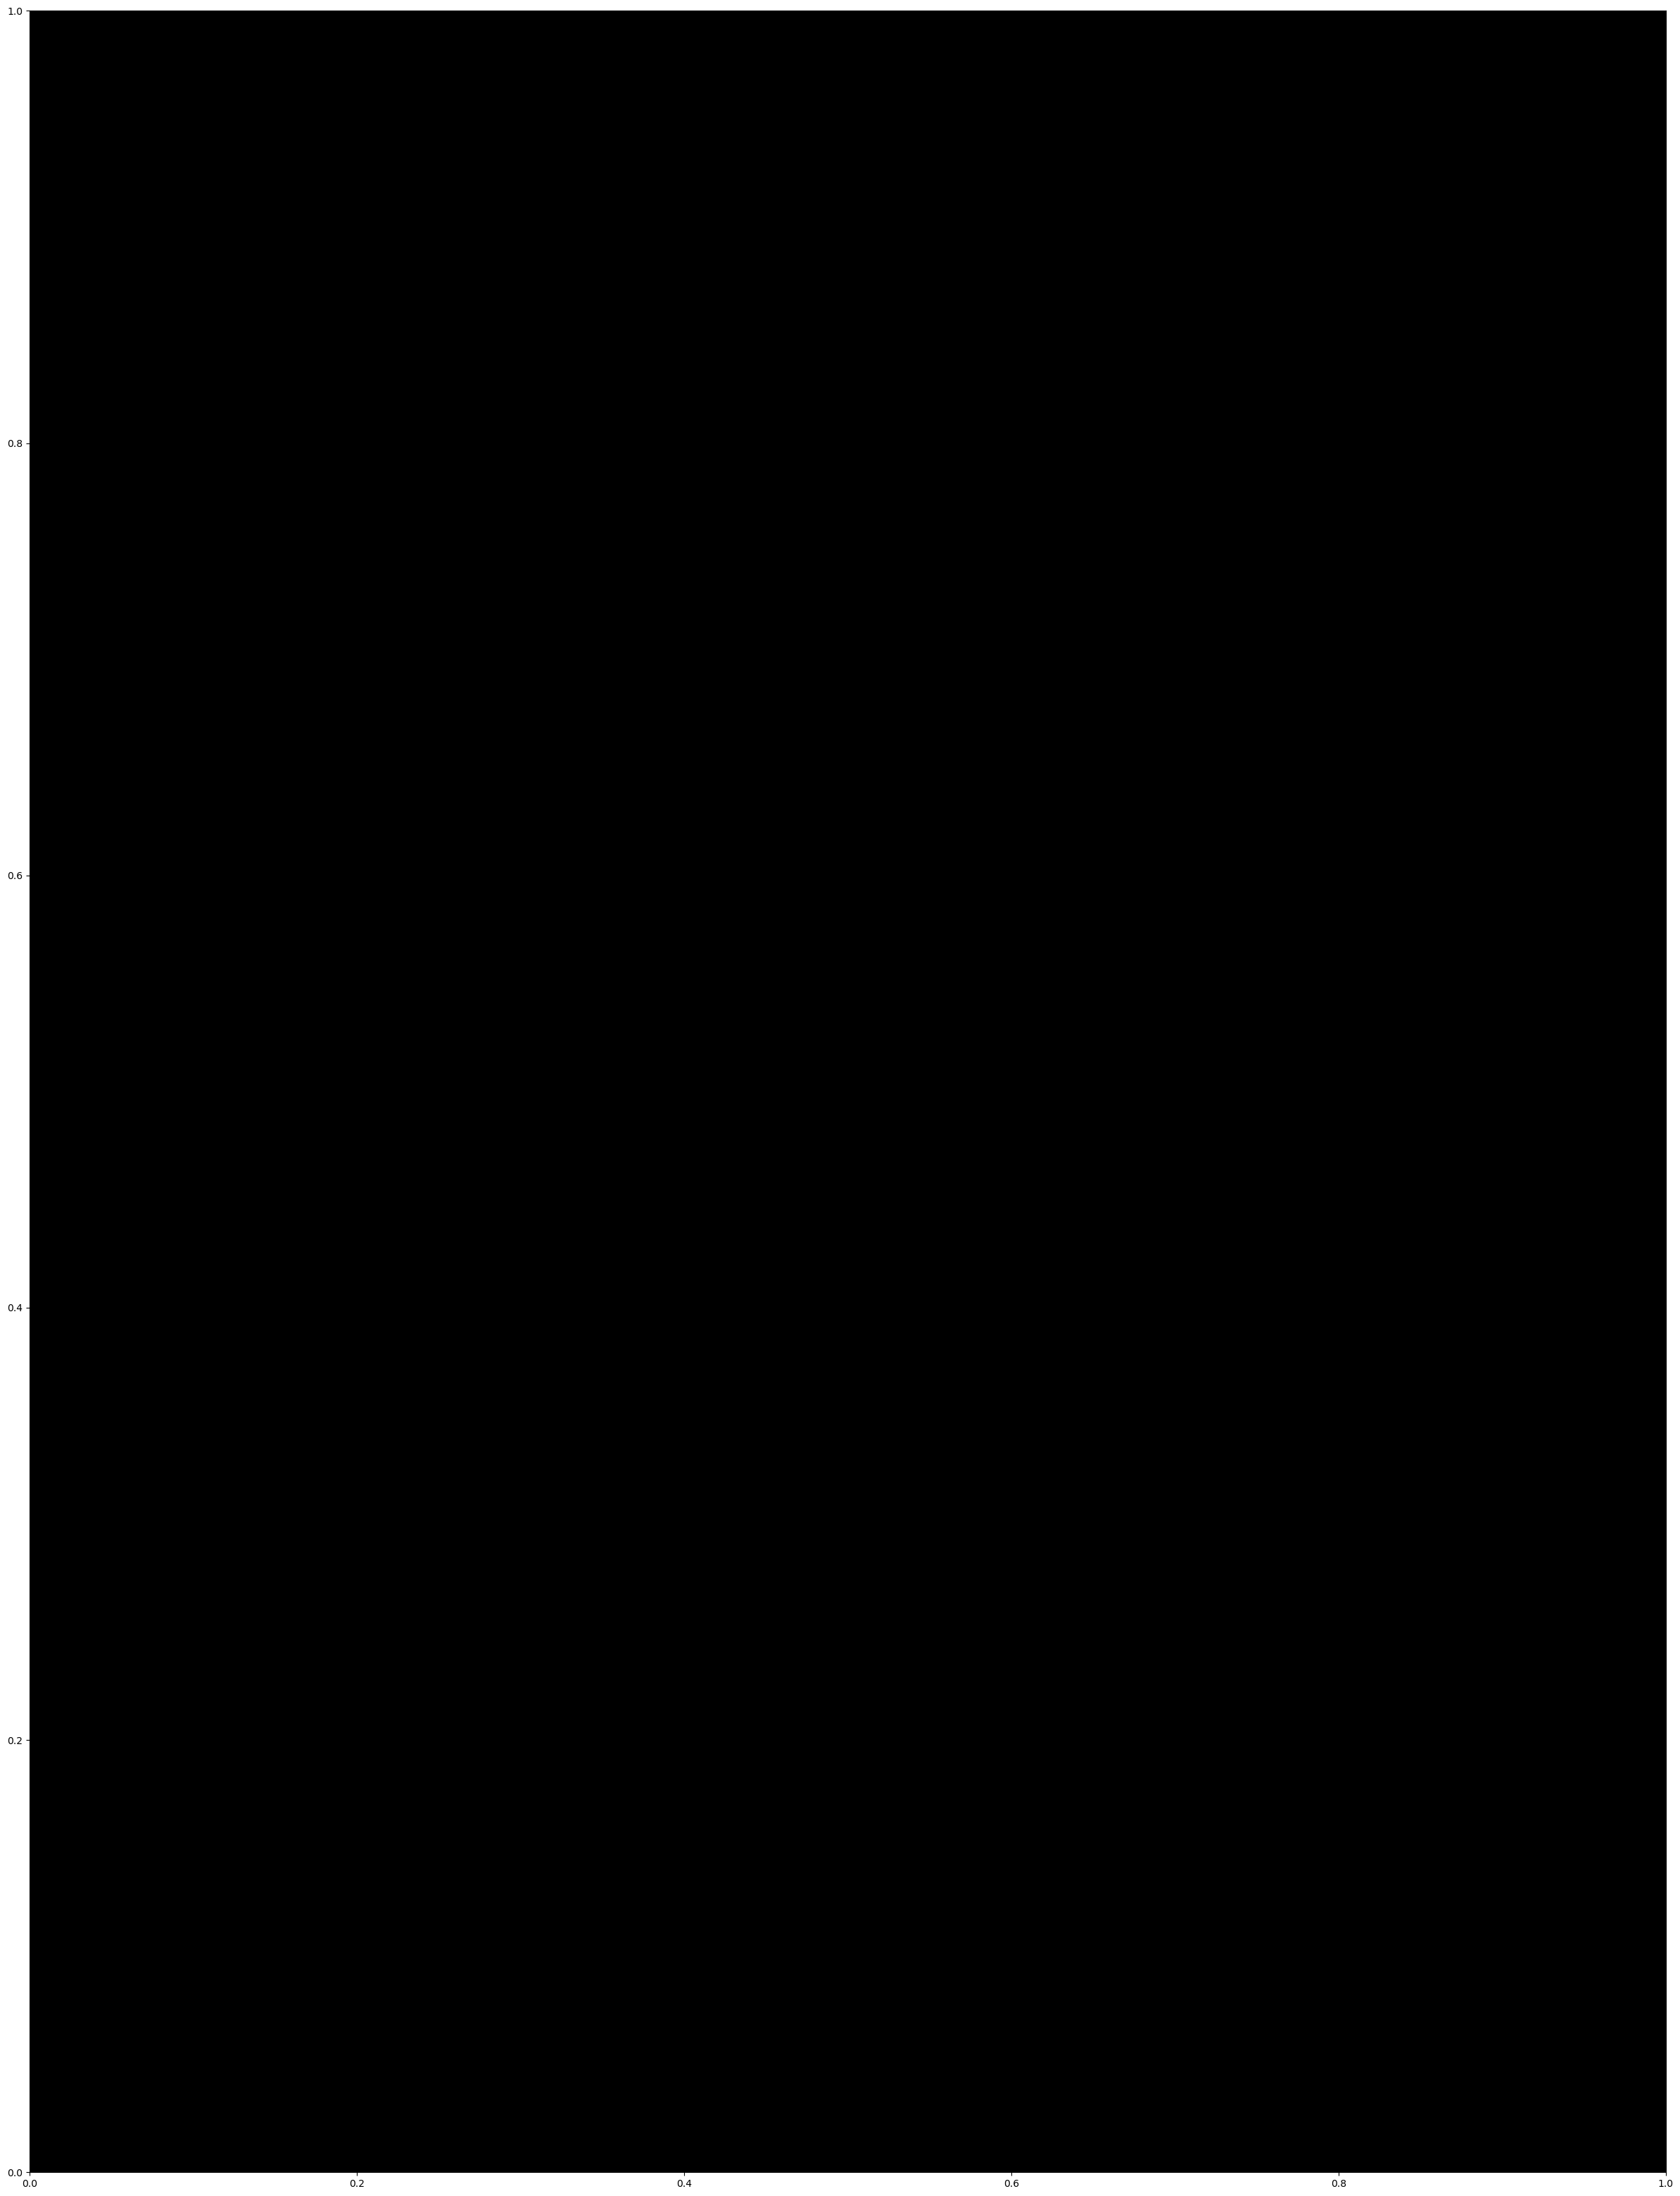

In [147]:
edges['normalized evictions'] = scaled_edges['scaled_evictions']

G = ox.graph_from_gdfs(nodes, edges)
ec = ox.plot.get_edge_colors_by_attr(G, attr = 'normalized evictions', cmap= 'hot')

fig, ax = ox.plot_graph(G, node_size=1, node_color = 'grey', edge_color=ec, edge_linewidth=2, figsize=(30,40), edge_alpha=1, bgcolor='black')

In [12]:
edges.head()

osmid               name  \
u        v        key                                                       
42421728 42435337 0                          195743153  Central Park West   
         42421731 0    [420625565, 420625573, 5668966]  West 106th Street   
         42432736 0           [1271523197, 1271523198]  Central Park West   
42421731 42437916 0                            5671485   Manhattan Avenue   
         42432737 0                          195743186   Manhattan Avenue   

                           highway maxspeed  oneway reversed   length  \
u        v        key                                                   
42421728 42435337 0      secondary   25 mph   False     True   85.345   
         42421731 0      secondary      NaN   False    False  138.033   
         42432736 0      secondary   25 mph   False    False   86.274   
42421731 42437916 0    residential      NaN   False     True   86.149   
         42432737 0    residential      NaN   False    False   85.968   

                                                                geometry  \
u        v        key                                                      
42421728 42435337 0    LINESTRING (-73.96004 40.79805, -73.96011 40.7...   
         42421731 0    LINESTRING (-73.96004 40.79805, -73.96017 40.7...   
         42432736 0    LINESTRING (-73.96004 40.79805, -73.95996 40.7...   
42421731 42437916 0    LINESTRING (-73.96147 40.79865, -73.96154 40.7...   
         42432737 0    LINESTRING (-73.96147 40.79865, -73.96140 40.7...   

                      lanes  ref access bridge tunnel width junction  \
u        v        key                                                  
42421728 42435337 0     NaN  NaN    NaN    NaN    NaN   NaN      NaN   
         42421731 0     NaN  NaN    NaN    NaN    NaN   NaN      NaN   
         42432736 0     NaN  NaN    NaN    NaN    NaN   NaN      NaN   
42421731 42437916 0     NaN  NaN    NaN    NaN    NaN   NaN      NaN   
         42432737 0     NaN  NaN    NaN    NaN    NaN   NaN      NaN   

                       evictions  normalized evictions  
u        v        key                                   
42421728 42435337 0            0              0.000000  
         42421731 0            3              0.294359  
         42432736 0            1              0.147180  
42421731 42437916 0            0              0.000000  
         42432737 0            2              0.233274

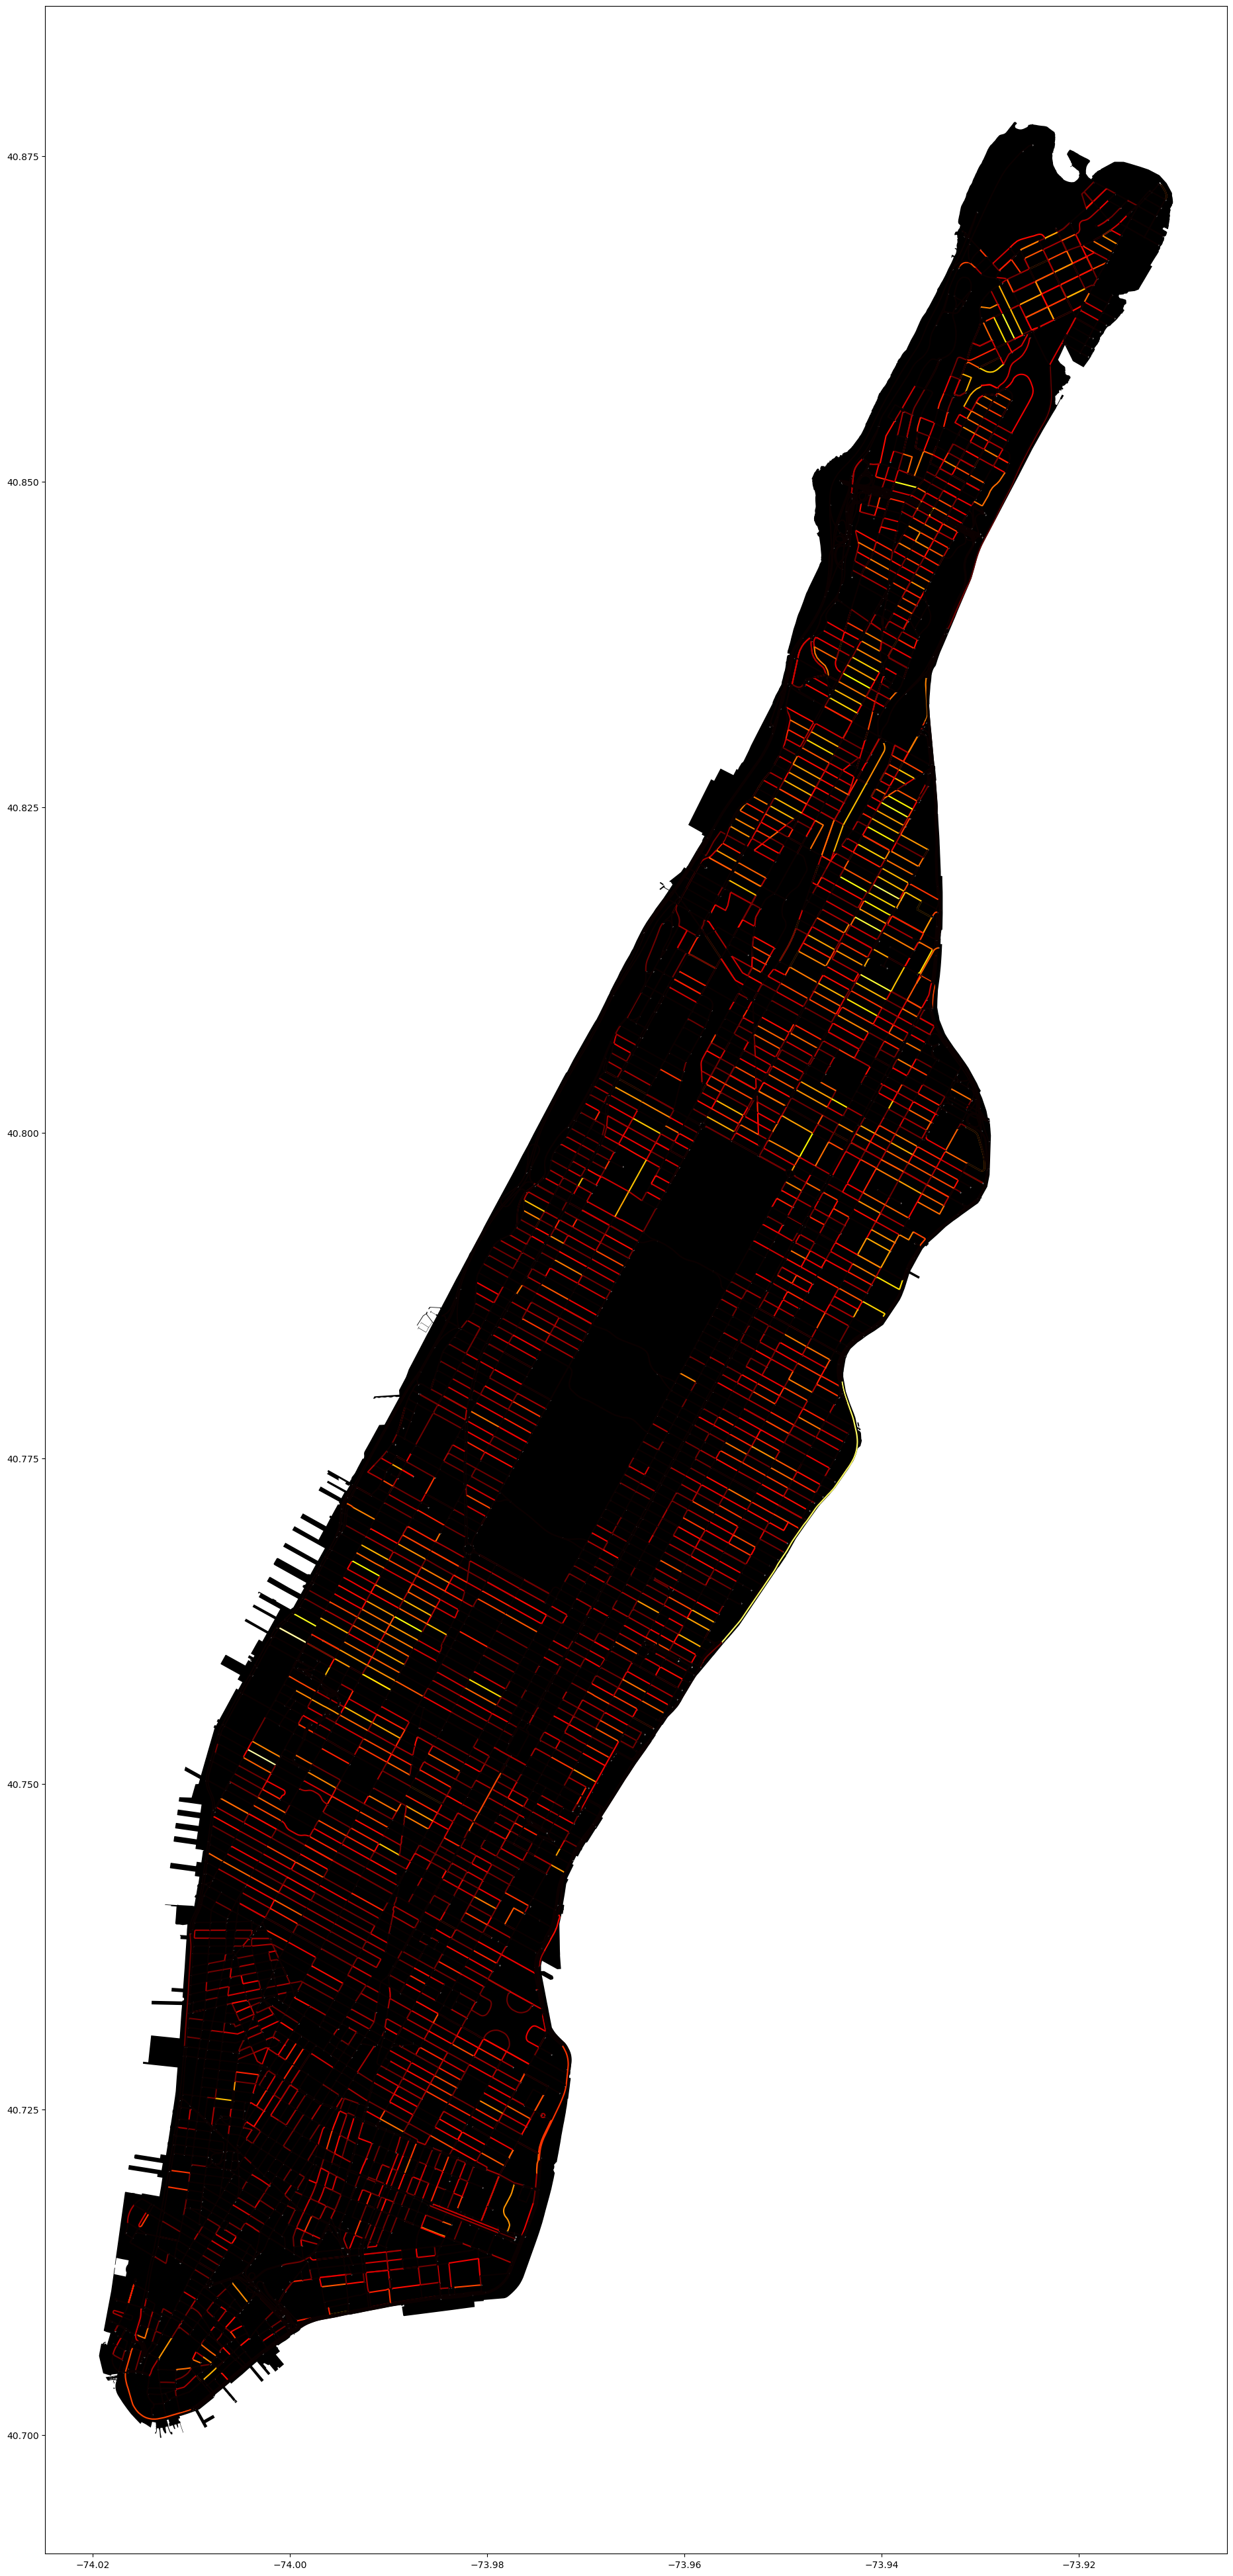

In [13]:
fig, ax = plt.subplots(figsize=(30,50))
area.plot(ax = ax, facecolor = 'black')
edges.plot(ax = ax, column = 'normalized evictions', cmap = 'hot', linewidth = 1.5)
nodes.plot(ax= ax, color = 'white', markersize = .1)
# property_gdf.plot(ax= ax,  markersize = 0.5, color = 'blue')

plt.show()

PROPERTY GRAPH

In [14]:
property_data = open(r'H:\03_AIA\01_GRAPHML\cleaned_property_data.csv')
property_df = pd.read_csv(property_data)


C:\Users\jfoo\AppData\Local\Temp\ipykernel_1052\2371170273.py:2: DtypeWarning: Columns (1,5) have mixed types. Specify dtype option on import or set low_memory=False.
  property_df = pd.read_csv(property_data)


In [15]:
geometry = gpd.points_from_xy(property_df['Longitude'], property_df['Latitude'])
property_gdf = gpd.GeoDataFrame(property_df, geometry= geometry)
property_gdf.set_crs(epsg= 4326)

Unnamed: 0        BBLE  BORO  BLOCK   LOT EASEMENT  \
0              3514  1009281654     1    928  1654      NaN   
1              3519  1009281661     1    928  1661      NaN   
2              3544  1010511417     1   1051  1417      NaN   
3              7066  1006371201     1    637  1201      NaN   
4             10598  1002791006     1    279  1006      NaN   
...             ...         ...   ...    ...   ...      ...   
1341054     8925107  1019480024     1   1948    24      NaN   
1341055     8925108  1021440003     1   2144     3      NaN   
1341056     8925110  1021410029     1   2141    29      NaN   
1341057     8925111  1020251006     1   2025  1006      NaN   
1341058     8925112  1021100018     1   2110    18      NaN   

                         OWNER BLDGCL TAXCLASS  LTFRONT  ...    Borough  \
0                          NaN     R4        2        0  ...  MANHATTAN   
1                          NaN     R4        2        0  ...  MANHATTAN   
2                          NaN     R4        2        0  ...  MANHATTAN   
3                          NaN     R8       2C        0  ...  MANHATTAN   
4                  U CHOI WONG     R1       2C        0  ...  MANHATTAN   
...                        ...    ...      ...      ...  ...        ...   
1341054  510 MANHATTAN AFFORDA     G7        4       25  ...  MANHATTAN   
1341055  45 & 47 WADWORTH AVEN     I9        4       50  ...  MANHATTAN   
1341056        THE ASCONIA LLC     D7        2      139  ...  MANHATTAN   
1341057  VAZQUEZ, DANIEL CASAN     R2        2       72  ...  MANHATTAN   
1341058  432-434 WEST 163RD ST     C1        2       50  ...  MANHATTAN   

          Latitude  Longitude  Community Board  Council District  \
0        40.736451 -73.978732            106.0               2.0   
1        40.736451 -73.978732            106.0               2.0   
2        40.759212 -73.994510            104.0               3.0   
3        40.735330 -74.009670            102.0               3.0   
4        40.712189 -73.997843            103.0               1.0   
...            ...        ...              ...               ...   
1341054  40.807889 -73.953676            110.0               9.0   
1341055  40.846186 -73.937623            112.0              10.0   
1341056  40.843846 -73.938775            112.0              10.0   
1341057  40.818687 -73.941926            110.0               9.0   
1341058  40.835993 -73.938142            112.0              10.0   

         Census Tract        BIN                                NTA  \
0                64.0  1086124.0                           Gramercy   
1                64.0  1086124.0                           Gramercy   
2               115.0  1088437.0                            Clinton   
3                75.0  1012003.0                       West Village   
4                27.0  1003389.0                          Chinatown   
...               ...        ...                                ...   
1341054         257.0  1000000.0               Central Harlem South   
1341055         263.0  1089928.0           Washington Heights South   
1341056         253.0  1063463.0           Washington Heights South   
1341057         230.0  1060373.0  Central Harlem North-Polo Grounds   
1341058       24301.0  1062592.0           Washington Heights South   

             New Georeferenced Column                    geometry  
0        POINT (-73.978732 40.736451)  POINT (-73.97873 40.73645)  
1        POINT (-73.978732 40.736451)  POINT (-73.97873 40.73645)  
2         POINT (-73.99451 40.759212)  POINT (-73.99451 40.75921)  
3          POINT (-74.00967 40.73533)  POINT (-74.00967 40.73533)  
4        POINT (-73.997843 40.712189)  POINT (-73.99784 40.71219)  
...                               ...                         ...  
1341054  POINT (-73.953676 40.807889)  POINT (-73.95368 40.80789)  
1341055  POINT (-73.937623 40.846186)  POINT (-73.93762 40.84619)  
1341056  POINT (-73.938775 40.843846)  POINT (-73.93878 40.84385)  
1

In [16]:
nearest_edges = ox.distance.nearest_edges(G, property_gdf['geometry'].x, property_gdf['geometry'].y)
edge_values = {edge: [] for edge in nearest_edges}

In [17]:
nodes, edges = ox.graph_to_gdfs(G)
edges.head()

osmid               name  \
u        v        key                                                       
42421728 42435337 0                          195743153  Central Park West   
         42421731 0    [420625565, 420625573, 5668966]  West 106th Street   
         42432736 0           [1271523197, 1271523198]  Central Park West   
42435337 42437916 0                            5670640  West 105th Street   
         42421728 0                          195743153  Central Park West   

                           highway maxspeed  oneway reversed   length  \
u        v        key                                                   
42421728 42435337 0      secondary   25 mph   False     True   85.345   
         42421731 0      secondary      NaN   False    False  138.033   
         42432736 0      secondary   25 mph   False    False   86.274   
42435337 42437916 0    residential   25 mph    True    False  137.996   
         42421728 0      secondary   25 mph   False    False   85.345   

                                                                geometry  \
u        v        key                                                      
42421728 42435337 0    LINESTRING (-73.96004 40.79805, -73.96011 40.7...   
         42421731 0    LINESTRING (-73.96004 40.79805, -73.96017 40.7...   
         42432736 0    LINESTRING (-73.96004 40.79805, -73.95996 40.7...   
42435337 42437916 0    LINESTRING (-73.96053 40.79738, -73.96065 40.7...   
         42421728 0    LINESTRING (-73.96053 40.79738, -73.96049 40.7...   

                       evictions  normalized evictions lanes  ref access  \
u        v        key                                                      
42421728 42435337 0            0              0.000000   NaN  NaN    NaN   
         42421731 0            3              0.294359   NaN  NaN    NaN   
         42432736 0            1              0.147180   NaN  NaN    NaN   
42435337 42437916 0            3              0.294359     1  NaN    NaN   
         42421728 0            0              0.000000   NaN  NaN    NaN   

                      junction bridge tunnel width  
u        v        key                               
42421728 42435337 0        NaN    NaN    NaN   NaN  
         42421731 0        NaN    NaN    NaN   NaN  
         42432736 0        NaN    NaN    NaN   NaN  
42435337 42437916 0        NaN    NaN    NaN   NaN  
         42421728 0        NaN    NaN    NaN   NaN

In [18]:
for i, edge in enumerate(nearest_edges):
    edge_values[edge].append(property_gdf.iloc[i]['AVTOT'])

In [ ]:
# print(list(islice(edge_values.items(), 1)))

In [ ]:
for edge, values in edge_values.items():
    avg_value = np.mean(values)
    u, v, key = edge
    edges.loc[(u,v,key), 'Average Value'] = avg_value

edges = edges.fillna(0)

In [20]:
non_zero = edges[edges['Average Value']>0]
min_non_zero = non_zero['Average Value'].min
min_non_zero


<bound method Series.min of u           v           key
42421728    42421731    0      1.020108e+05
            42432736    0      1.260371e+05
42435337    42437916    0      1.077599e+05
            42421728    0      1.468919e+05
            42435336    0      9.430400e+06
                                   ...     
7802856341  7802856352  0      1.290758e+07
7802856372  42443329    0      8.683408e+05
            7802856349  0      1.357805e+07
8840333851  42453952    0      7.934890e+07
            42428391    0      2.713570e+06
Name: Average Value, Length: 6450, dtype: float64>

In [21]:
log_weights = np.log(edges['Average Value'] + 1)
norm_weights = (log_weights - log_weights.min()) / (log_weights.max() - log_weights.min())
edges['Normalized Average Value'] = norm_weights
non_zero_edges = edges[edges['Normalized Average Value'] > 0]

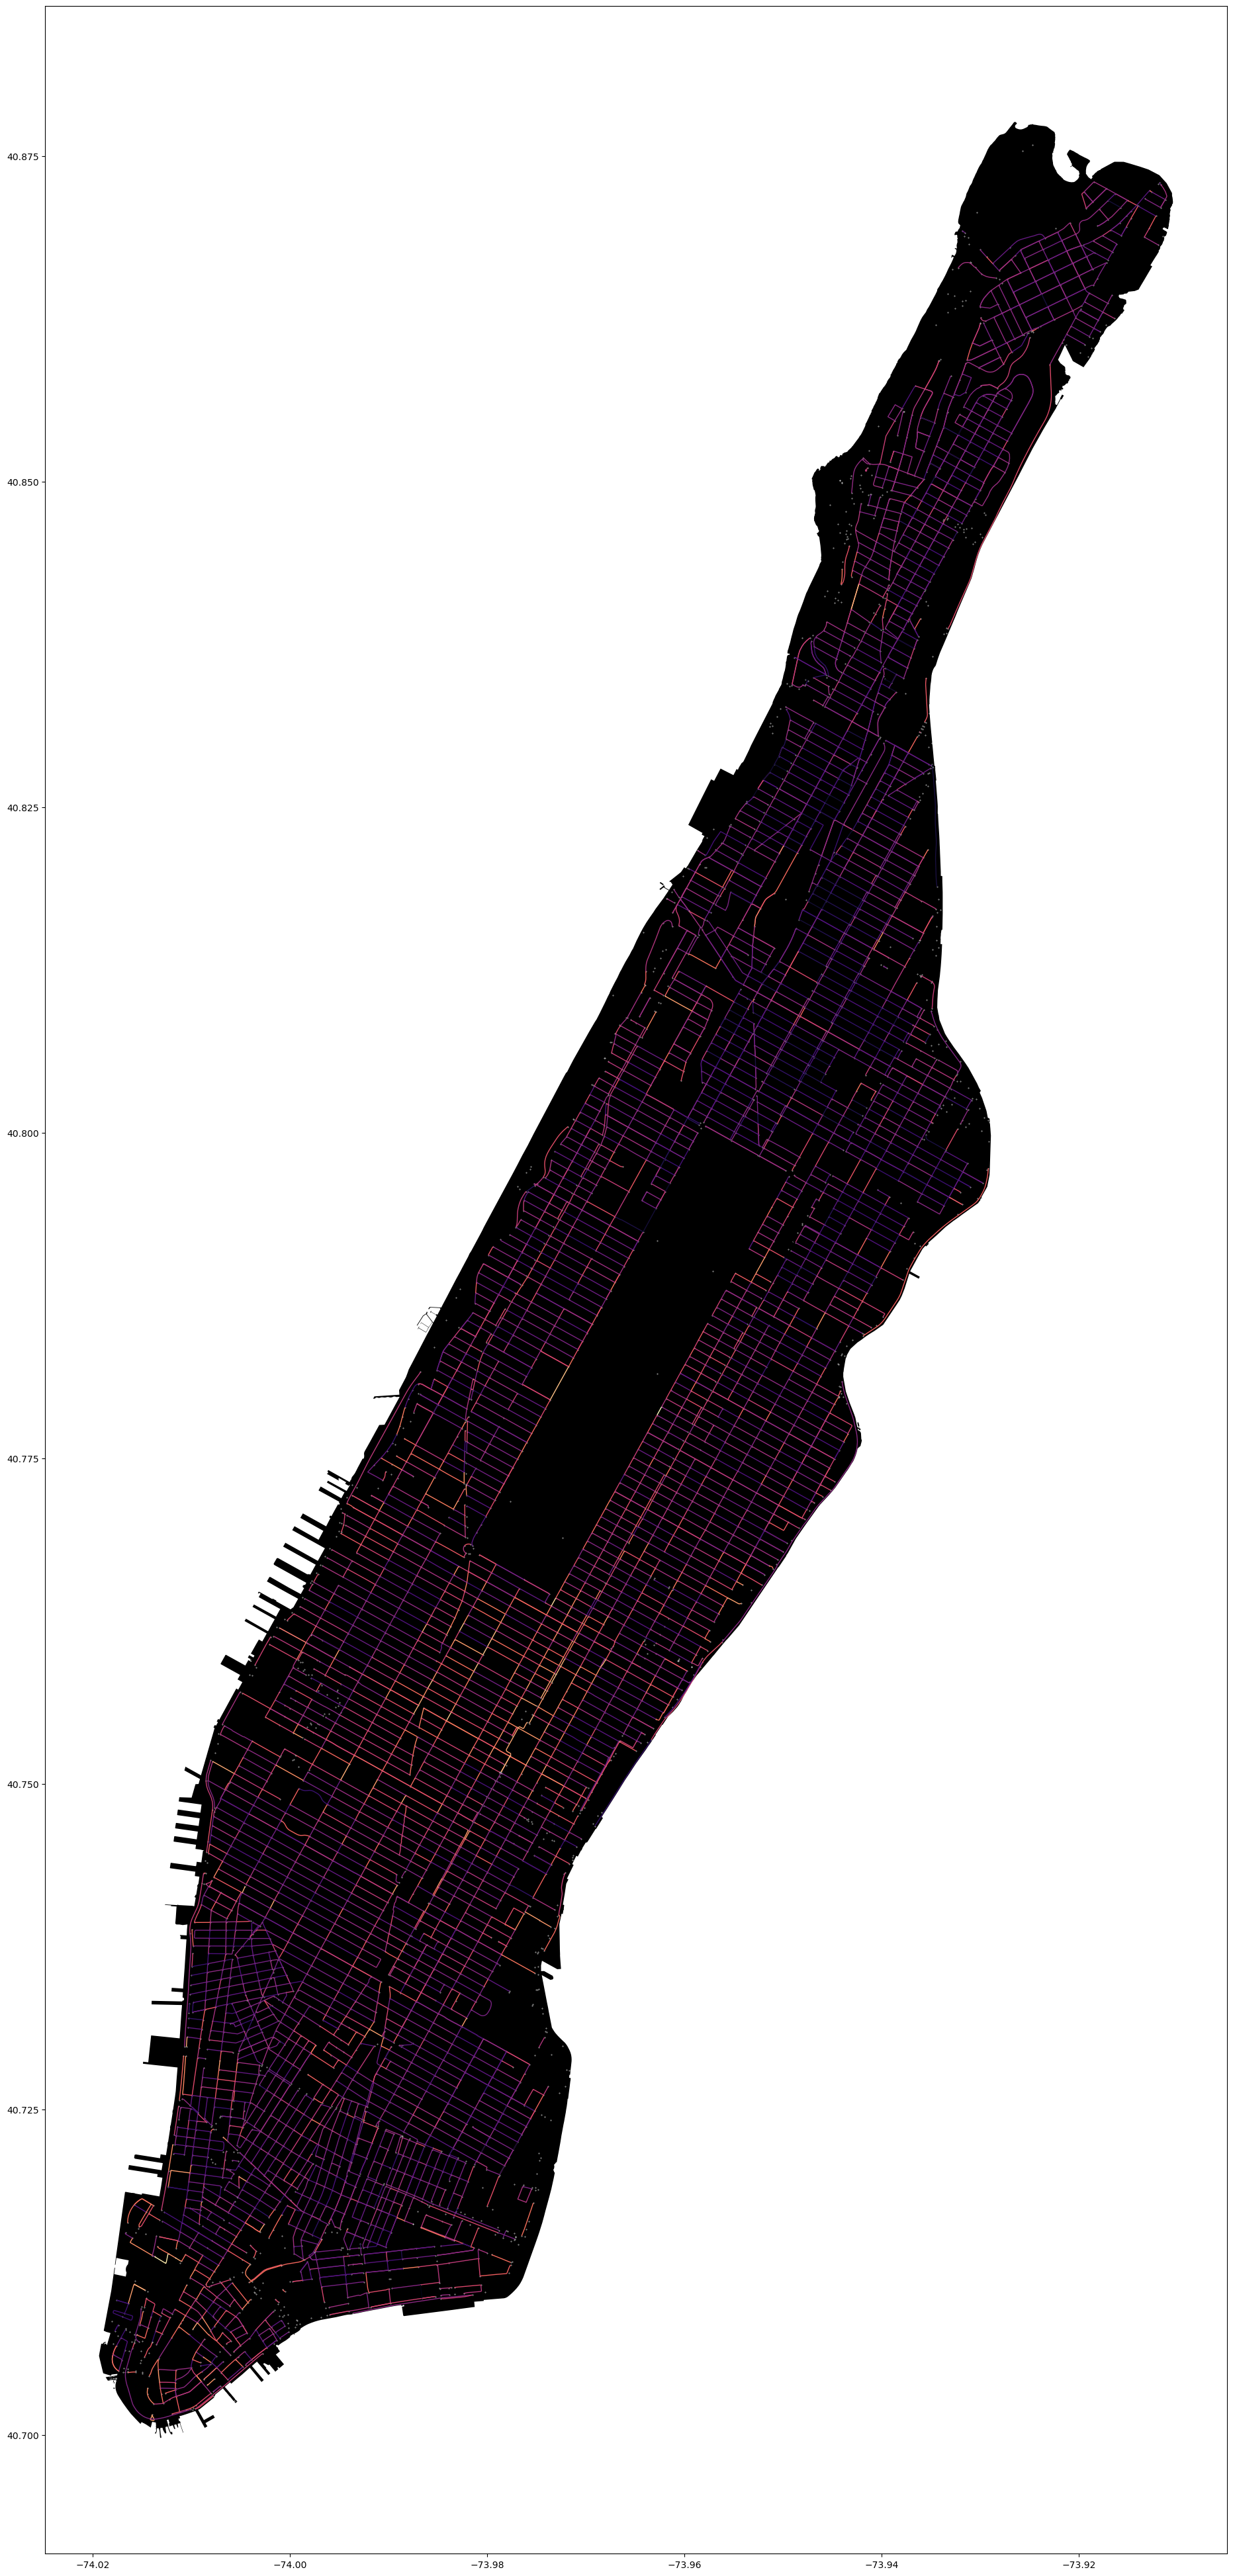

In [22]:
fig, ax = plt.subplots(figsize=(30,50))
area.plot(ax = ax, facecolor = 'black')
non_zero_edges.plot(ax = ax, column = 'Normalized Average Value', cmap = 'magma', linewidth = 1)
nodes.plot(ax= ax, color = 'white', markersize = .1)
# property_gdf.plot(ax= ax,  markersize = 0.5, color = 'blue')

plt.show()

RENT

FEATURE ANALYSIS

In [31]:
import phik
from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns
import warnings

In [32]:
edges.head()

osmid               name  \
u        v        key                                                       
42421728 42435337 0                          195743153  Central Park West   
         42421731 0    [420625565, 420625573, 5668966]  West 106th Street   
         42432736 0           [1271523197, 1271523198]  Central Park West   
42435337 42437916 0                            5670640  West 105th Street   
         42421728 0                          195743153  Central Park West   

                           highway maxspeed  oneway reversed   length  \
u        v        key                                                   
42421728 42435337 0      secondary   25 mph   False     True   85.345   
         42421731 0      secondary        0   False    False  138.033   
         42432736 0      secondary   25 mph   False    False   86.274   
42435337 42437916 0    residential   25 mph    True    False  137.996   
         42421728 0      secondary   25 mph   False    False   85.345   

                                                                geometry  \
u        v        key                                                      
42421728 42435337 0    LINESTRING (-73.96004 40.79805, -73.96011 40.7...   
         42421731 0    LINESTRING (-73.96004 40.79805, -73.96017 40.7...   
         42432736 0    LINESTRING (-73.96004 40.79805, -73.95996 40.7...   
42435337 42437916 0    LINESTRING (-73.96053 40.79738, -73.96065 40.7...   
         42421728 0    LINESTRING (-73.96053 40.79738, -73.96049 40.7...   

                       evictions  normalized evictions lanes ref access  \
u        v        key                                                     
42421728 42435337 0            0              0.000000     0   0      0   
         42421731 0            3              0.294359     0   0      0   
         42432736 0            1              0.147180     0   0      0   
42435337 42437916 0            3              0.294359     1   0      0   
         42421728 0            0              0.000000     0   0      0   

                      junction bridge tunnel width  Average Value  \
u        v        key                                               
42421728 42435337 0          0      0      0     0       0.000000   
         42421731 0          0      0      0     0  102010.825397   
         42432736 0          0      0      0     0  126037.125413   
42435337 42437916 0          0      0      0     0  107759.857143   
         42421728 0          0      0      0     0  146891.866887   

                       Normalized Average Value  
u        v        key                            
42421728 42435337 0                    0.000000  
         42421731 0                    0.544653  
         42432736 0                    0.554641  
42435337 42437916 0                    0.547243  
         42421728 0                    0.561873

In [33]:
attributes_to_check = ['Normalized Average Value', 'normalized evictions']
data_to_check = edges[attributes_to_check]
warnings.filterwarnings("ignore")

plt.figure(figsize=(10, 5))
heatmap = sns.heatmap(data_to_check.phik_matrix(), annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [86]:
G_enriched = ox.graph_from_gdfs(nodes, edges)

In [95]:
edges.head()

osmid               name  \
u        v        key                                                       
42421728 42435337 0                          195743153  Central Park West   
         42421731 0    [420625565, 420625573, 5668966]  West 106th Street   
         42432736 0           [1271523197, 1271523198]  Central Park West   
42435337 42437916 0                            5670640  West 105th Street   
         42421728 0                          195743153  Central Park West   

                           highway maxspeed  oneway reversed   length  \
u        v        key                                                   
42421728 42435337 0      secondary   25 mph   False     True   85.345   
         42421731 0      secondary        0   False    False  138.033   
         42432736 0      secondary   25 mph   False    False   86.274   
42435337 42437916 0    residential   25 mph    True    False  137.996   
         42421728 0      secondary   25 mph   False    False   85.345   

                                                                geometry  \
u        v        key                                                      
42421728 42435337 0    LINESTRING (-73.96004 40.79805, -73.96011 40.7...   
         42421731 0    LINESTRING (-73.96004 40.79805, -73.96017 40.7...   
         42432736 0    LINESTRING (-73.96004 40.79805, -73.95996 40.7...   
42435337 42437916 0    LINESTRING (-73.96053 40.79738, -73.96065 40.7...   
         42421728 0    LINESTRING (-73.96053 40.79738, -73.96049 40.7...   

                       evictions  normalized evictions lanes ref access  \
u        v        key                                                     
42421728 42435337 0            0              0.000000     0   0      0   
         42421731 0            0              0.000000     0   0      0   
         42432736 0            1              0.147180     0   0      0   
42435337 42437916 0            3              0.294359     1   0      0   
         42421728 0            0              0.000000     0   0      0   

                      junction bridge tunnel width  Average Value  \
u        v        key                                               
42421728 42435337 0          0      0      0     0       0.000000   
         42421731 0          0      0      0     0  102010.825397   
         42432736 0          0      0      0     0  126037.125413   
42435337 42437916 0          0      0      0     0  107759.857143   
         42421728 0          0      0      0     0  146891.866887   

                       Normalized Average Value  
u        v        key                            
42421728 42435337 0                    0.000000  
         42421731 0                    0.544653  
         42432736 0                    0.554641  
42435337 42437916 0                    0.547243  
         42421728 0                    0.561873

In [99]:
for node in G_enriched.nodes():
    neighbors = list(G_enriched.neighbors(node))

    if len(neighbors) > 0:
    
        for neighbor in neighbors:

            neighbor_evictions=[]
            neighbor_value = []

            neighbor_evictions.append(G_enriched.get_edge_data(node, neighbor)[0]['evictions'])
            neighbor_value.append(G_enriched.get_edge_data(node, neighbor)[0]['Average Value'])

            avg_evictions = sum(neighbor_evictions)/len(neighbors)
            avg_value = sum(neighbor_value)/len(neighbors)

        G_enriched.nodes[node]['avg_evictions'] = avg_evictions
        G_enriched.nodes[node]['avg_value'] = avg_value

    else:
        G_enriched.nodes[node]['avg_evictions'] = 0
        G_enriched.nodes[node]['avg_value'] = 0


In [101]:
nodes, edges = ox.graph_to_gdfs(G_enriched)

In [104]:
nodes_xy=[[nodes.loc[i].geometry.x, nodes.loc[i].geometry.y] for i in tqdm(nodes.index)]

100%|██████████| 4501/4501 [00:00<00:00, 14508.08it/s]


In [117]:
kmeans = KMeans(n_clusters=7, random_state=42, n_init="auto").fit(nodes_xy)

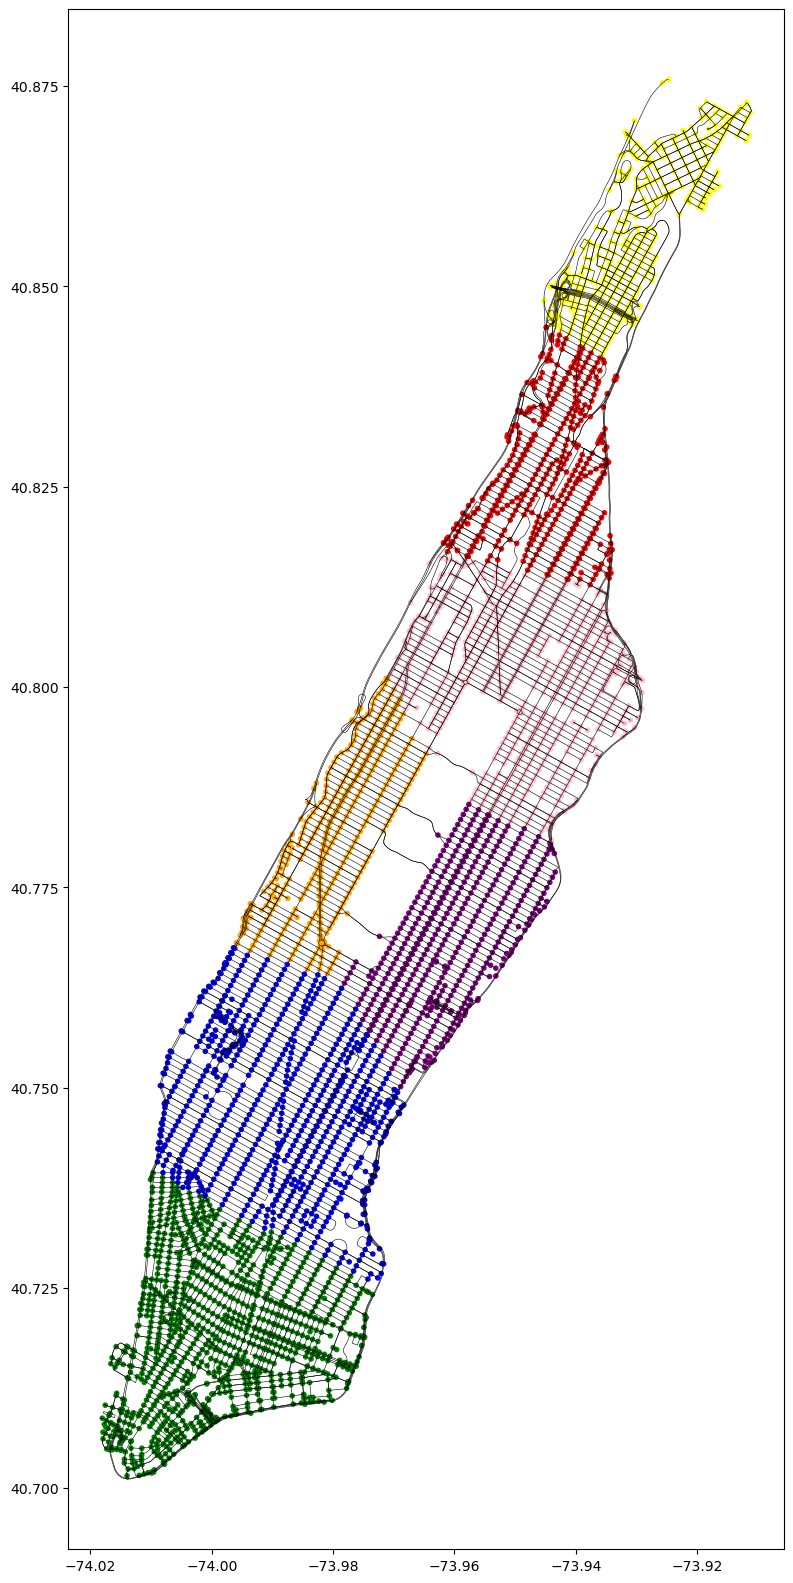

In [118]:
colors_dict={0:"red", 1:"blue", 2:"orange", 3:"green", 4:"pink", 5:"purple", 6:"yellow"}
fig, ax = plt.subplots(figsize=(20,20))
colors=[colors_dict[i] for i in kmeans.labels_]
edges.plot(ax=ax, linewidth=0.4, edgecolor='black')
nodes.plot(ax=ax, color=colors, markersize=9)
plt.show()

In [109]:
nodes["proximity_cluster_index"]=kmeans.labels_
nodes

y          x          highway  street_count  \
osmid                                                              
42421728     40.798048 -73.960044  traffic_signals             3   
42435337     40.797376 -73.960535  traffic_signals             3   
42421731     40.798654 -73.961474  traffic_signals             4   
42432736     40.798726 -73.959547  traffic_signals             3   
42437916     40.797976 -73.961970              NaN             4   
...                ...        ...              ...           ...   
6216836461   40.795446 -73.931986         crossing             1   
6331080434   40.734191 -73.975034              NaN             1   
9566822907   40.831192 -73.951337              NaN             1   
11868048948  40.758976 -73.959252              NaN             1   
11868048950  40.759001 -73.959233              NaN             1   

             avg_evictions     avg_value  ref                    geometry  \
osmid                                                                       
42421728          0.333333  4.201238e+04  NaN  POINT (-73.96004 40.79805)   
42435337          0.000000  3.143467e+06  NaN  POINT (-73.96053 40.79738)   
42421731          0.500000  4.219569e+04  NaN  POINT (-73.96147 40.79865)   
42432736          0.000000  0.000000e+00  NaN  POINT (-73.95955 40.79873)   
42437916          0.000000  1.633296e+04  NaN  POINT (-73.96197 40.79798)   
...                    ...           ...  ...                         ...   
6216836461        1.000000  1.325820e+07  NaN  POINT (-73.93199 40.79545)   
6331080434        2.000000  0.000000e+00  NaN  POINT (-73.97503 40.73419)   
9566822907        0.000000  0.000000e+00  NaN  POINT (-73.95134 40.83119)   
11868048948       0.000000  0.000000e+00  NaN  POINT (-73.95925 40.75898)   
11868048950       0.000000  0.000000e+00  NaN  POINT (-73.95923 40.75900)   

             proximity_cluster_index  
osmid                                 
42421728                           1  
42435337                           1  
42421731                           1  
42432736                           1  
42437916                           1  
...                              ...  
6216836461                         1  
6331080434                         0  
9566822907                         2  
11868048948                        5  
11868048950                        5  

[4501 rows x 9 columns]